In [77]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import norm, probplot
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
warnings.simplefilter("ignore")

In [39]:
def score_(X_train, X_valid, y_train, y_valid):
    '''
    Score model with Mean Absolute Error
    '''
    model = LinearRegression(n_jobs=5)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mae(y_valid, preds)

In [46]:
df = pd.read_excel('data/dados.xlsx')

In [47]:
# def get_area_type(row):
#     _v = df2[df2.url == row.url]
#     return _v.loc[_v.index[0], ['area', 'type']]

In [48]:
df['ID'] = df.url.map(lambda x : x.rsplit('-')[-1].replace('/', ''))

In [49]:
#removendo colunas desnecessárias
df.drop(columns=['address', 'amenities', 'title', 'address_class', 'url', 'geocode'], inplace=True)

Quais são os dados nulos?

In [50]:
df.isna().sum().sort_values()

bathrooms                 0
Condomínio                0
Preço c/ condomínio       0
IPTU                      0
type                      0
ID                        0
postcode                188
rent                    260
area                    260
bedrooms                324
suburb                  407
parking                 607
city_district          1031
dtype: int64

In [51]:
def trata_bairro(row):
    '''
    Função para retornar o campo bairro.
    '''
    if pd.isna(row['suburb']) and pd.isna(row['city_district']):
        return np.nan
    if not pd.isna(row['suburb']):
        return row['suburb']
    elif not pd.isna(row['city_district']):
        return row['city_district']
    return 'Analisar'
#     elif row['suburb'] == row['city_district']:
#         return row['city_district']
#     else: 
#         return 'Diferente'

In [52]:
df['bairro'] = df.apply(trata_bairro, axis=1)

Quais os registros sem bairro?

In [53]:
df[df.bairro == 'Analisar']

,bedrooms,bathrooms,parking,rent,Condomínio,Preço c/ condomínio,IPTU,suburb,city_district,postcode,area,type,ID,bairro


In [54]:
df.bairro.isna().sum()

323

Vamos remover os registros que não tenham valores na coluna bairro

In [55]:
df.dropna(subset=['bairro'], inplace=True)

Não precisamos mais das colunas `suburb` e `city_district` e `postcode` (talvez retornemos com o postcode)

In [56]:
df.drop(columns=['suburb', 'city_district', 'postcode'], inplace=True)

O Valor do `aluguel` + `Condomínio` é examtanet o valor do proço total? Sim!!

In [57]:
df=df.drop(columns=['Preço c/ condomínio','IPTU','Condomínio']).rename({
    'bedrooms':'Quartos',
    'bathrooms':'Banheiros',
    'rent':'Preco',
    'bairro':'Bairro',
    'parking': 'Estacionamento'
}, axis=1) #[~((df['rent'].astype(int) + df['Condomínio'].astype(int)) == df['Preço c/ condomínio'].astype(int))]

In [58]:
df.Quartos = df.Quartos.fillna(0).astype(int)

In [59]:
df.Estacionamento = df.Estacionamento.fillna(0)

Valores nulos?

In [60]:
df.isna().sum()

Quartos           0
Banheiros         0
Estacionamento    0
Preco             0
area              0
type              0
ID                0
Bairro            0
dtype: int64

In [61]:
df.reset_index(drop=True, inplace=True)

In [64]:
df.type = df.type.str.strip()

In [65]:
df[df.type == 'Aluguel'].Preco.mean()

33409.75475923852

In [66]:
df[df.type == 'Aluguel'].Preco.median()

2500.0

In [67]:
df.groupby(['type'], as_index=False).ID.count()

,type,ID
0,Aluguel,893
1,Compra,214
2,Não informado,396


In [68]:
df = df[df.type == 'Aluguel']

In [69]:
df= df[df.Preco < 50000].reset_index(drop=True)#.sort_values(by=['Preco'], ascending=False)

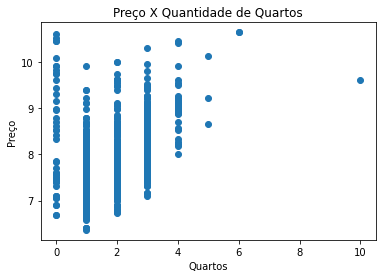

In [70]:
fig, ax= plt.subplots()
ax.scatter(x=df['Quartos'], y=np.log(df['Preco']))
plt.ylabel('Preço')
plt.xlabel('Quartos')
plt.title("Preço X Quantidade de Quartos")
plt.show()

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


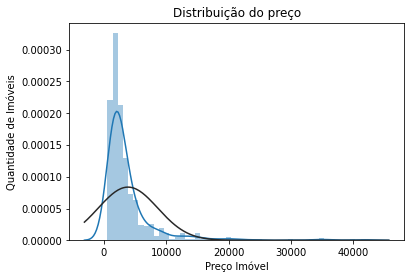

In [75]:
sns.distplot(df.Preco, fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição do preço')
plt.show()

Vamos ajustar o preço para uma distribuição `normal`

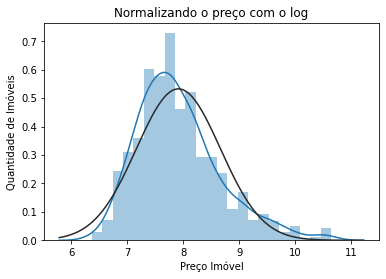

In [82]:
sns.distplot(np.log(df.Preco), fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Normalizando o preço com o log')
plt.show()

In [83]:
df.Preco = np.log(df.Preco)

In [84]:
df.Bairro = df.Bairro.astype("category")

In [85]:
X = df.drop(columns=['Preco', 'type'])
y = df['Preco']

### Aplicando OrdinalEncoder

In [86]:
# Vamos criar nossa base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Vamos criar uma cópia para evitar alterações
label_X_train = X_train.copy()
label_X_test = X_test.copy()

# Vamos aplicar o OrdinarEnconder para a coluna categoria, que no caso é apenas o bairro
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

label_X_train[['Bairro']] = ordinal_encoder.fit_transform(X_train[['Bairro']])
label_X_test[['Bairro']] = ordinal_encoder.transform(X_test[['Bairro']])

print("Mean Absolute Error com OrdinalEnconder:") 
print(score_(label_X_train, label_X_test, y_train, y_test))

Mean Absolute Error com OrdinalEnconder:
0.39196923902539


### Cross validation score

In [87]:
scores = cross_val_score(LinearRegression(fit_intercept=False, n_jobs=1, positive=True), label_X_train, y_train, cv=5)
scores

array([0.0187944 , 0.53705931, 0.56353485, 0.52732283, 0.52995758])

#### Criando um pipeline

In [89]:
n_estimators = 5
pipe = Pipeline(steps=[
    #('preprocessor', SimpleImputer()),
    ("normalizacao", MinMaxScaler()),
    ('model', LinearRegression(n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.48519985, 0.34142375, 0.37563715, 0.34462258, 0.37652179])